Trying the BP3D_CUDA algorithm - does the whole dataset at once. So fast! 

No documentation for this algorithm, but the name suggests it's _unfiltered_ backprojection. So the recon won't be as good, but maybe still useful if we do our own filtering beforehand (i.e., deconvolution on the projections?).

In [1]:
import astra
import numpy as np
from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt
import time
import gc

In [2]:
gc.collect()

PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-10 10pc 15um 3d phantom\2023-02-10 10pc 15um 3d phantom fa 400proj\1_1\1_1_MMStack_Pos0.ome.tif'

im = io.imread(PATH_TO_IMAGE)
print(im.shape)
print(im.max())

(400, 1392, 1040)
<class 'numpy.ndarray'>


In [4]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

# Preallocate Memory
reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

(1392, 400, 1040)


In [5]:
start = time.time()

### Configuration ##################################
output_dir = 'test_recon' # *filename* to save reconstructions to
save_reconstruction = True

num_of_projections = im.shape[1]
detector_rows = im.shape[0]  # Vertical size of detector [pixels].
detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)

proj_geom = \
    astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_rows, detector_cols, angles)
projections_id = astra.data3d.create('-sino', proj_geom, im)

vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('BP3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction_fbp = astra.data3d.get(reconstruction_id)

end = time.time()
print(f'Reconstructed in {end-start} s.')

# start = time.time()
# reconstruction_fbp[reconstruction_fbp < 0] = 0
# reconstruction_fbp /= np.max(reconstruction_fbp)
# reconstruction_fbp = np.round(reconstruction_fbp * 65535).astype(np.uint8)
# end = time.time()
# print(f'Rescaled in {end-start} s.')

if save_reconstruction:
    start = time.time()
    imsave(f'{output_dir}.tif', reconstruction_fbp)
    end = time.time()
    print(f'Saved to disk in {end-start} s.')
    

# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

Reconstructed in 21.792582273483276 s.
Saved to disk in 30.847872734069824 s.


In [6]:
np.max(reconstruction_fbp)

8282779.0

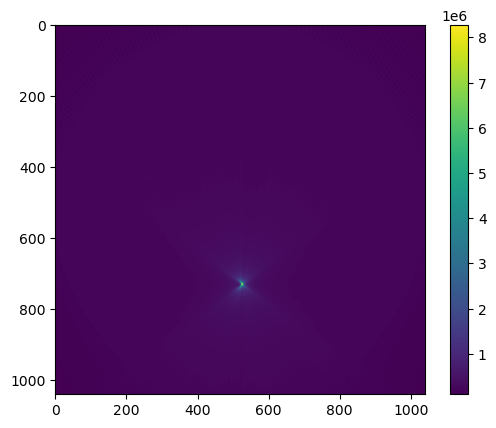

In [7]:
plt.imshow(reconstruction_fbp[696])
plt.colorbar()
plt.show()

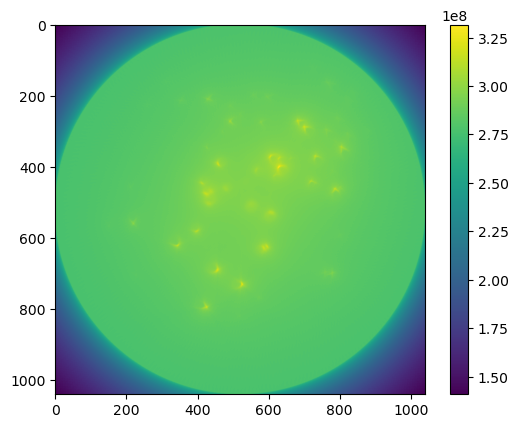

In [8]:
plt.imshow(np.sum(reconstruction_fbp, axis=0))
plt.colorbar()
plt.show()